In [3]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor

In [4]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.info()
train_data.head()

missing_val_count= (train_data.isnull().sum())
print(missing_val_count[missing_val_count > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
Age         177
Cabin       687
Embarked      2
dtype: int64


In [5]:
train_data.fillna({"Embarked":train_data["Embarked"].mode()[0]},inplace=True)
train_data.fillna({"Age": train_data['Age'].median()}, inplace=True)

In [6]:
dropped_columns = ['Name','Ticket','Cabin','PassengerId']
train_data = train_data.drop(columns=dropped_columns,axis=1)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [7]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
dropped_test_data = test_data.drop(columns=dropped_columns,axis=1)
dropped_test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


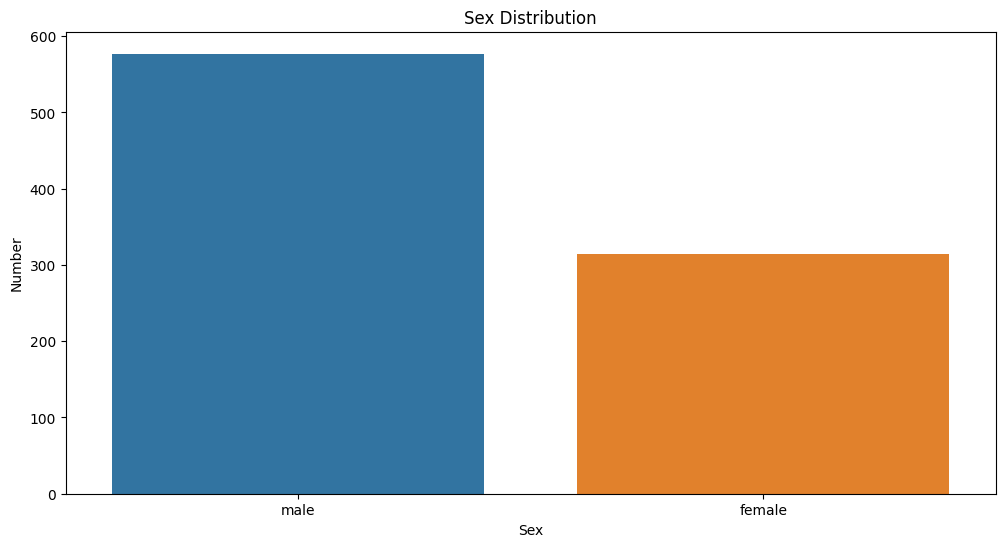

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x="Sex",data=train_data)
plt.ylabel("Number")
plt.title("Sex Distribution")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


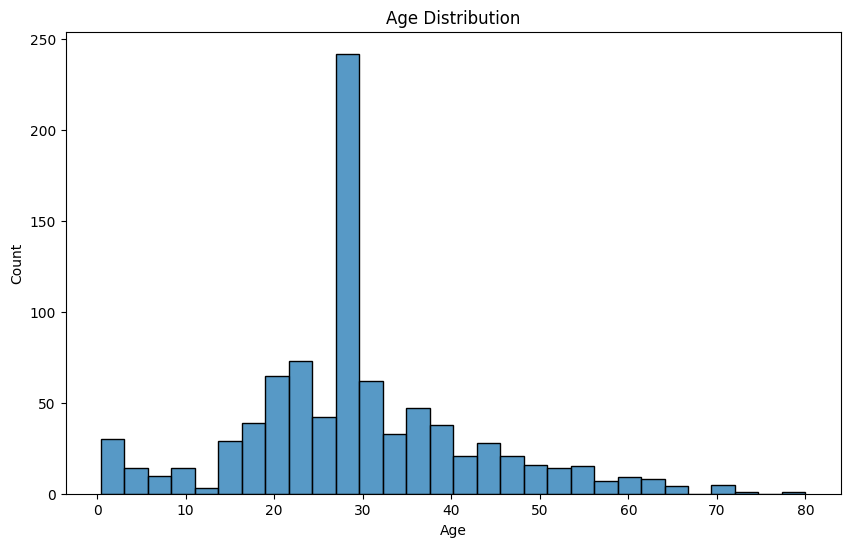

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(train_data["Age"])
plt.title("Age Distribution")
plt.show()

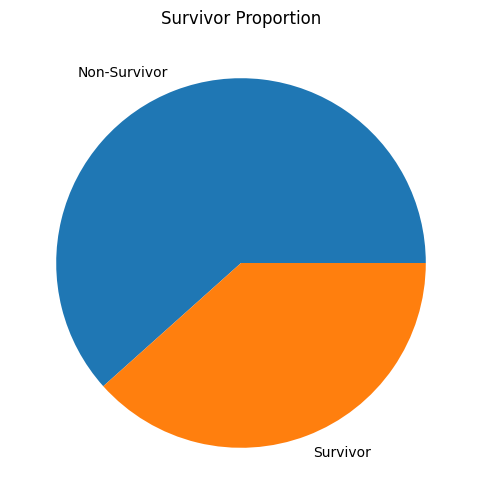

In [11]:
plt.figure(figsize=(10,6))
non_survivor,survivor = train_data['Survived'].value_counts().items()
plt.pie(pd.array([non_survivor[1],survivor[1]]),
labels=['Non-Survivor','Survivor']);
plt.title("Survivor Proportion")
plt.show()

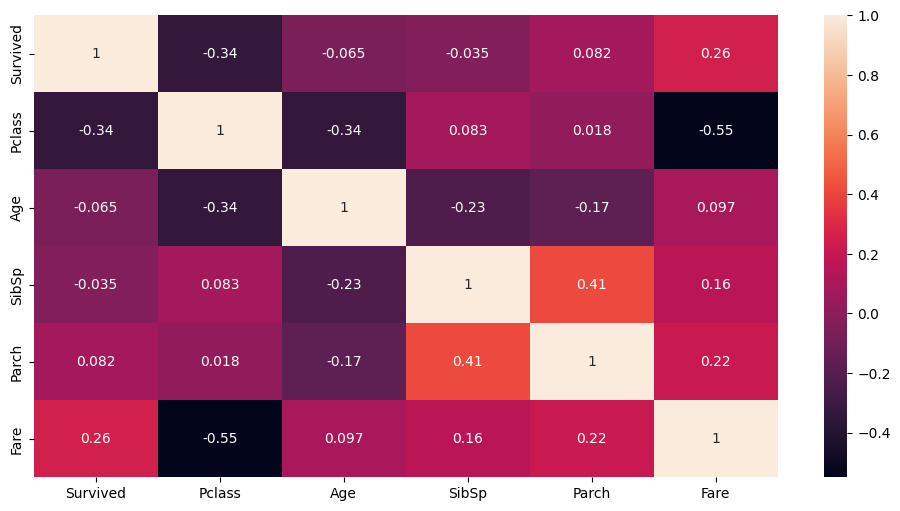

In [12]:
corred_data = train_data.select_dtypes(exclude=['object'])
corr_matrix = corred_data.corr()

plt.figure(figsize=(12,6))
sns.heatmap(data=corr_matrix,annot=True)
plt.show()

In [35]:
y = train_data["Survived"]
X = train_data.drop('Survived', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

numerical_transformer = SimpleImputer(strategy='constant')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

models = {
    "RF": RandomForestRegressor(n_estimators=10, random_state=42),
    "LR": LogisticRegression(solver='lbfgs', max_iter=400),
    "XGB": XGBRegressor(n_estimators=500, learning_rate=0.05)
}

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)
                              ])
    scores = -1 * cross_val_score(pipeline, X, y,
                              cv=10,
                              scoring='neg_mean_absolute_error')
    
    print(f"{name} MAE scores: {scores}")
    print(f"Average score: {scores.mean()}\n")


RF MAE scores: [0.31687566 0.25333863 0.27683904 0.21946544 0.21614231 0.22554823
 0.211697   0.27093345 0.18319925 0.2013015 ]
Average score: 0.2375340508014665

LR MAE scores: [0.2        0.20224719 0.24719101 0.19101124 0.21348315 0.23595506
 0.21348315 0.21348315 0.19101124 0.16853933]
Average score: 0.20764044943820226

XGB MAE scores: [0.28079217 0.23818719 0.29005382 0.25859144 0.22669906 0.219056
 0.22968043 0.27826914 0.19659513 0.20720213]
Average score: 0.24251264904046468



In [39]:
final_model = LogisticRegression(solver='lbfgs', max_iter=400)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', final_model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(dropped_test_data)

# Check predictions against actual values
print("Actual values:\n", y_test.head())
print("Predictions:\n", predictions[:5])

# Prepare submission
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

Actual values:
 862    1
223    0
84     1
680    0
535    1
Name: Survived, dtype: int64
Predictions:
 [0 0 0 0 1]
